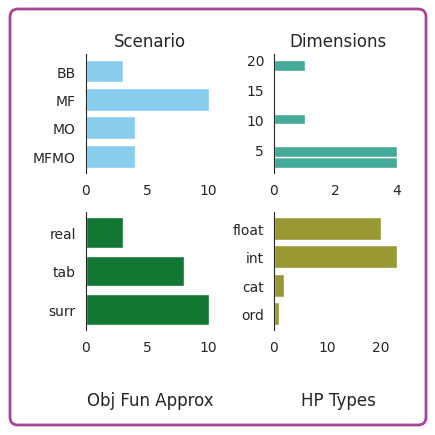

In [128]:
data = {
    "Scenario": {
        "BB": 3,
        "MF": 10,
        "MO": 4,
        "MFMO": 4,
    },
    "Dimensions":
        [2,4,5,5,5,3,3,3,10,20],
    "Obj Fun Approx": {
        "real": 3,
        "tab": 8,
        "surr": 10
    },
    "HP Types": {
        "float": 20,
        "int": 23,
        "cat": 2,
        "ord": 1,
    }
}

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from rich import inspect

sns.set_style("white")

fig = plt.figure(figsize=(4,4))
# inspect(fig.patch, all=True)
# fig.patch.set_linewidth(10)
# fig.patch.set_edgecolor('pink')  # substitute 'k' for black
# bbox = fig.patch.get_bbox()
# inspect(fig.patch, all=True)
# frame = mpatches.FancyBboxPatch(xy=(1,1), width=1, height=1, color="pink", fill=False)
# frame.set_in_layout(False)
# fig.add_artist(frame)

# # Add a rounded frame to the figure
# bbox_props = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="none", linewidth=2)

# # Create the FancyBboxPatch
# frame = mpatches.FancyBboxPatch((0, 0), 1, 1, transform=fig.transFigure, **bbox_props)
# frame.set_in_layout(False)

# Add the frame to the figure's patches
# fig.patches.append(frame)

palette = ["#FDC5F5", "#F7AEF8", "#B388EB", "#8093F1", "#72DDF7"]
palette = ["#003844", "#006C67", "#F194B4", "#FFB100", "#FFEBC6"]
tol_muted_palette = [
    "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77",
    "#CC6677", "#882255", "#AA4499", "#DDDDDD"
]
palette = [
    tol_muted_palette[0],
    tol_muted_palette[1],
    tol_muted_palette[2],
    tol_muted_palette[3],
    tol_muted_palette[7],
]

axes = fig.subplots(nrows=2, ncols=2)
for i, (key, val) in enumerate(data.items()):
    ax = axes.flatten()[i]
    if key != "Dimensions": 
        ax.barh(y=list(val.keys())[::-1], width=list(val.values())[::-1], color=palette[i])
    else:
        ax.hist(x=val, orientation="horizontal", color=palette[i])
    y = None
    if i >= 2:
        y = -0.7
    ax.set_title(key, y=y)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    # ax.axis["left"].major_ticklabels.set_ha("left")
fig.set_tight_layout(True)

fig_width, fig_height = fig.get_size_inches()
fig_dpi = fig.get_dpi()

# Create the rounded frame
bbox_props = dict(boxstyle="round,pad=0.02", edgecolor=palette[-1], facecolor="none", linewidth=2)

# Create the FancyBboxPatch
frame = mpatches.FancyBboxPatch((0, 0), 1, 1, transform=fig.transFigure, **bbox_props)

# Add the frame to the figure's patches
fig.patches.append(frame)

# # Adjust layout to make more space between the axes and the title
# fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.1, wspace=0.1)

# # Add a title in the center of the figure
# fig.text(0.5, 0.5, "Benchmark",
#          bbox=dict(boxstyle='square,pad=1', fc='none', ec='none'),
#           ha='center', va='center', fontsize=16, weight='bold', transform=fig.transFigure)



fig.savefig("benchmark_footprint_demo.png", bbox_inches="tight", dpi=300)


plt.show()

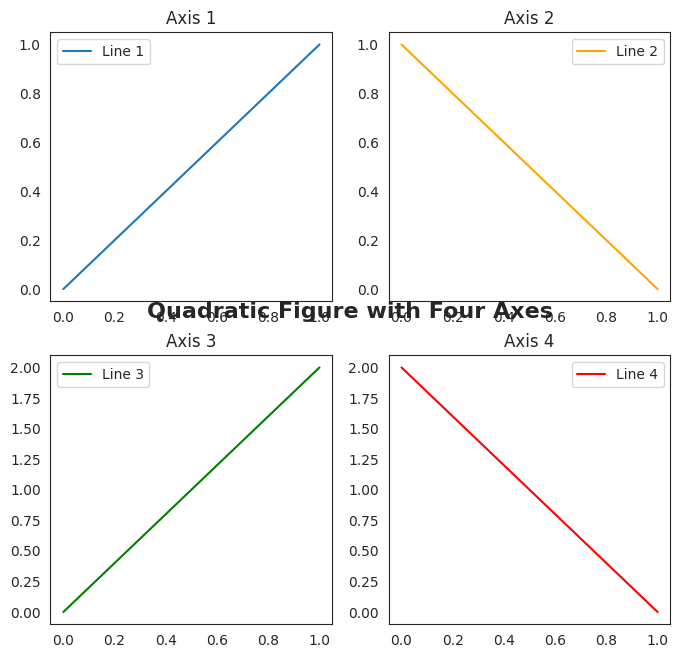

In [108]:
import matplotlib.pyplot as plt

# Create a quadratic figure
fig = plt.figure(figsize=(8, 8))

# Create four subplots
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# Adjust layout to make space for the title
fig.subplots_adjust(top=0.85)

# Add a title in the center of the figure
fig.text(0.5, 0.5, "Quadratic Figure with Four Axes", ha='center', va='center', fontsize=16, weight='bold', transform=fig.transFigure)

# Example data for each subplot
ax1.plot([0, 1], [0, 1], label='Line 1')
ax2.plot([0, 1], [1, 0], label='Line 2', color='orange')
ax3.plot([0, 1], [0, 2], label='Line 3', color='green')
ax4.plot([0, 1], [2, 0], label='Line 4', color='red')

# Add titles and labels to each subplot
ax1.set_title('Axis 1')
ax2.set_title('Axis 2')
ax3.set_title('Axis 3')
ax4.set_title('Axis 4')

# Show legends
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# Display the plot
plt.show()

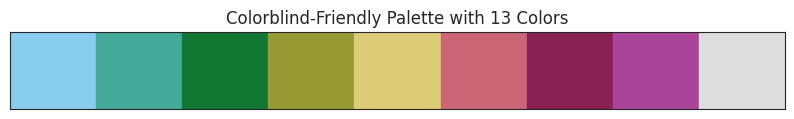

In [75]:
import matplotlib.pyplot as plt

# Define a colorblind-friendly color palette with 13 colors
colorblind_palette = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00",
    "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00"
]
colorblind_palette = [
    "#51A3A3",
    "#75485E",
    "#CB904D",
    "#DFCC74",
    "#C3E991"
]
colorblind_palette = ["#FDC5F5", "#F7AEF8", "#B388EB", "#8093F1", "#72DDF7"]
colorblind_palette = ["#003844", "#006C67", "#F194B4", "#FFB100", "#FFEBC6"]
colorblind_palette = [
    "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77",
    "#CC6677", "#882255", "#AA4499", "#DDDDDD"
]



# Create a sample plot to show the color palette
fig, ax = plt.subplots(figsize=(10, 1), dpi=100)

for i, color in enumerate(colorblind_palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

ax.set_xlim(0, len(colorblind_palette))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.title("Colorblind-Friendly Palette with 13 Colors")
plt.show()